In [1]:
#Copy the code and change the name for other artists
artist_name = "Drake"

In [2]:
import pandas as pd
import codecs
import json
from pandas.io.json import json_normalize
import re

In [3]:
#Machine learning libraries for Text analysis
import nltk  # machine learning with text
from nltk import download as nltk_download
from nltk.corpus import stopwords, wordnet  # List of common words
from nltk.tokenize import word_tokenize  # Split text into significant forms
from nltk.stem import WordNetLemmatizer  # Reduce words to their root form
from nltk import pos_tag  # Tag words with parts of speech
from collections import defaultdict, Counter  # Dictionaries that have a backup value
from sklearn.feature_extraction.text import CountVectorizer  # Convert text to sparse matrices
from textblob import TextBlob  # Sentiment analysis
from gensim.models.ldamodel import LdaModel  # Topic extraction
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS  # ngrams
from gensim.models.phrases import Phraser  # ngrams
from gensim import corpora, models, similarities  # Vectorization
import pyLDAvis
from wordcloud import WordCloud  # Create wordclouds
import matplotlib.pylab as plt

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Run next 2 cells only if you want to pull data from Genius

In [ ]:
from lyricsgenius import Genius

genius = Genius('JOSfSO0Cn0Y3avlw_ItRLdmwFj3s-36fjS-POUolMGFiWkUiE_zHXfQZVsOOqbxA', timeout=10)
artist = genius.search_artist(artist_name, max_songs = 300) # use max_songs=10 parameter to limit to 10 songs

In [ ]:
artist_json = artist.save_lyrics()

# Start here to use the data from the file on disk

In [4]:
#load the file
name_string = artist_name.replace(' ', '')
lyricsFile = "Lyrics_"+str(name_string)+".json"
with open(lyricsFile) as json_data:
    data = json.load(json_data)

# convert to dataframe
df = pd.DataFrame(data['songs'])
artist_df = df[['full_title', 'title', 'artist', 'lyrics', 'featured_artists', 'release_date']]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Lyric Analysis

## Cleaning the lyrics

In [5]:
# convert everything to lower case
artist_df.lyrics = artist_df.lyrics.str.lower()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"[intro]\nyou used to call me on my\nyou used to, you used to\nyeah\n\n[chorus]\nyou used to call me on my cell phone\nlate-night when you need my love\ncall me on my cell phone\nlate-night when you need my love\nand i know when that hotline bling\nthat can only mean one thing\ni know when that hotline bling\nthat can only mean one thing\n\n[verse 1]\never since i left the city, you\ngot a reputation for yourself now\neverybody knows and i feel left out\ngirl, you got me down, you got me stressed out\n'cause ever since i left the city, you\nstarted wearing less and goin' out more\nglasses of champagne out on the dance floor\nhangin' with some girls i've never seen before\n\n[chorus]\nyou used to call me on my cell phone\nlate-night when you need my love\ncall me on my cell phone\nlate-night when you need my love\ni know when that hotline bling\nthat can only mean one thing\ni know when that hotline bling\nthat can only mean one thing\n\n[verse 2]\never since i left the city, you, you, 

In [7]:
# remove the embed, share, copy at the end of each lyric
artist_df.lyrics = artist_df.lyrics.replace(to_replace="embedshare url:copyembed:copy", value="", regex=True) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Remove quotes
artist_df.lyrics = artist_df.lyrics.replace(to_replace="(\u2019)", value="'", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# convert common contractions to the full word or phrase
artist_df.lyrics = artist_df.lyrics.replace(to_replace="wont", value="will not", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="wouldn't", value="wouldnt", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="can't", value="cannot", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="don't", value="dont", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'re", value=" are", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="wanna", value="want to", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="ain't", value="aint", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="gotta", value="got to", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'ll", value=" will", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="lil'", value="little", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="hol'", value="hold", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="y'all", value="you all", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# convert more common contractions to the full word or phrase
artist_df.lyrics = artist_df.lyrics.replace(to_replace="it's", value="it is", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="that's", value="that is", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="i've", value="i have", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="i'm", value="i am", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="you're", value="you are", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="you've", value="you have", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="n' ", value="ng ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'n ", value="ing ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'s ", value="s ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=" 'em ", value="them ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="&", value="and", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Remove common interjections, or singing sounds
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"aah|aagh|ayy|ay|ooh|oh|huh|ah", value="", regex=True) 
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"hmm|mmm|brr", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"yeah", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"woah", value="", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# remove verse, chorus, bridge, intro , outro anotations 
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"\[[^]]*\]", value="", regex=True) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# get rid of tabs, new line, return symbols and parentheses
artist_df.lyrics = artist_df.lyrics.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=" ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=[r"\(|\)", ""], value=" ", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


" you used to call me on my you used to, you used to ye   you used to call me on my cell phone late-night when you need my love call me on my cell phone late-night when you need my love and i know when that hotline bling that can only mean one thing i know when that hotline bling that can only mean one thing   ever since i left the city, you got a reputation for yourself now everybody knows and i feel left out girl, you got me down, you got me stressed out 'cause ever since i left the city, you started wearing less and going out more glasses of champagne out on the dance floor hanging with some girls i have never seen before   you used to call me on my cell phone late-night when you need my love call me on my cell phone late-night when you need my love i know when that hotline bling that can only mean one thing i know when that hotline bling that can only mean one thing   ever since i left the city, you, you, you you and me, we just dont get along you make me feel like i did you wrong 

In [15]:
# remove any other symbols except letters, numbers and underscore
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"\W", value=" ", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' you used to call me on my you used to  you used to ye   you used to call me on my cell phone late night when you need my love call me on my cell phone late night when you need my love and i know when that hotline bling that can only mean one thing i know when that hotline bling that can only mean one thing   ever since i left the city  you got a reputation for yourself now everybody knows and i feel left out girl  you got me down  you got me stressed out  cause ever since i left the city  you started wearing less and going out more glasses of champagne out on the dance floor hanging with some girls i have never seen before   you used to call me on my cell phone late night when you need my love call me on my cell phone late night when you need my love i know when that hotline bling that can only mean one thing i know when that hotline bling that can only mean one thing   ever since i left the city  you  you  you you and me  we just dont get along you make me feel like i did you wrong 

In [17]:
artist_df_clean = artist_df

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# Tokenize
artist_df.lyrics = artist_df.lyrics.apply(word_tokenize)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['you',
 'used',
 'to',
 'call',
 'me',
 'on',
 'my',
 'you',
 'used',
 'to',
 'you',
 'used',
 'to',
 'ye',
 'you',
 'used',
 'to',
 'call',
 'me',
 'on',
 'my',
 'cell',
 'phone',
 'late',
 'night',
 'when',
 'you',
 'need',
 'my',
 'love',
 'call',
 'me',
 'on',
 'my',
 'cell',
 'phone',
 'late',
 'night',
 'when',
 'you',
 'need',
 'my',
 'love',
 'and',
 'i',
 'know',
 'when',
 'that',
 'hotline',
 'bling',
 'that',
 'can',
 'only',
 'mean',
 'one',
 'thing',
 'i',
 'know',
 'when',
 'that',
 'hotline',
 'bling',
 'that',
 'can',
 'only',
 'mean',
 'one',
 'thing',
 'ever',
 'since',
 'i',
 'left',
 'the',
 'city',
 'you',
 'got',
 'a',
 'reputation',
 'for',
 'yourself',
 'now',
 'everybody',
 'knows',
 'and',
 'i',
 'feel',
 'left',
 'out',
 'girl',
 'you',
 'got',
 'me',
 'down',
 'you',
 'got',
 'me',
 'stressed',
 'out',
 'cause',
 'ever',
 'since',
 'i',
 'left',
 'the',
 'city',
 'you',
 'started',
 'wearing',
 'less',
 'and',
 'going',
 'out',
 'more',
 'glasses',
 'of',
 

## Analysis: common 2 and 3 word phrases found in the lyrics

In [20]:
# Divide the lyrics into "sentences" so that the phrases don't straddle songs.   Each song = one sentence
sentences = []
for l in artist_df.lyrics:
    sentences.append(l)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Number of sentences should equal the number of songs
len(sentences)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


300

In [22]:
# check our result on the first sentence
sentences[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['and',
 'they',
 'wishing',
 'and',
 'wishing',
 'and',
 'wishing',
 'and',
 'wishin',
 'they',
 'wishing',
 'on',
 'me',
 'ye',
 'i',
 'been',
 'moving',
 'calm',
 'dont',
 'start',
 'no',
 'trouble',
 'with',
 'me',
 'tryna',
 'keep',
 'it',
 'peaceful',
 'is',
 'a',
 'struggle',
 'for',
 'me',
 'dont',
 'pull',
 'up',
 'at',
 '6',
 'am',
 'to',
 'cuddle',
 'with',
 'me',
 'you',
 'know',
 'how',
 'i',
 'like',
 'it',
 'when',
 'you',
 'loving',
 'on',
 'me',
 'i',
 'dont',
 'want',
 'to',
 'die',
 'for',
 'them',
 'to',
 'miss',
 'me',
 'yes',
 'i',
 'see',
 'the',
 'things',
 'that',
 'they',
 'wishing',
 'on',
 'me',
 'hope',
 'i',
 'got',
 'some',
 'brothers',
 'that',
 'outlive',
 'me',
 'they',
 'gong',
 'tell',
 'the',
 'story',
 'shit',
 'was',
 'different',
 'with',
 'me',
 'gods',
 'plan',
 'gods',
 'plan',
 'i',
 'hold',
 'back',
 'sometimes',
 'i',
 'won',
 't',
 'yuh',
 'i',
 'feel',
 'good',
 'sometimes',
 'i',
 'dont',
 'dont',
 'i',
 'finessed',
 'down',
 'weston',
 

In [23]:
# Look for frequently used 2 word combinations
from itertools import groupby

# Build the bigram model
bigram = Phrases(sentences)


# Find bigrams in the songs
two_word_phrases = []
i=0
while i < len(sentences): 
    bigrams = bigram[sentences[i]]
    for s in bigrams:
        if len(re.findall('_', s)) > 0:
            two_word_phrases.append(s)
    i = i + 1
two_word_phrases_df = pd.DataFrame(two_word_phrases, columns = ['Phrases'])
test = two_word_phrases_df.groupby(by = "Phrases").size().reset_index(name='counts')
test.sort_values(by = 'counts', ascending = False).head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
64,can_not,475
427,want_to,410
401,this_shit,174
325,right_now,144
193,have_been,143


In [24]:
# Looking for 3 word combinations 

# Build the trigram models
trigram = Phrases(bigram[sentences])

tri = []

# Construct trigram list looking at all songs
i=0
while i < len(sentences): 
    songtrigram = trigram[bigram[sentences[i]]]
    for s in songtrigram:
        if len(re.findall('_', s)) > 1:
            tri.append(s)
    i = i + 1

tri_df = pd.DataFrame(tri, columns = ['Phrases'])
test_tri = tri_df.groupby(by = "Phrases").size().reset_index(name='counts')
test_tri.sort_values(by = 'counts', ascending = False).head(30)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
109,it_is_yours,80
3,a_lot_of,76
191,want_to_be,53
140,on_my_mind,35
102,in_this_bitch,33
156,shout_out_to,26
14,ama_go_hard,24
150,s_my_name,23
134,nigga_we_made,23
12,am_ready_for,23


In [25]:
fourgram = Phrases(trigram[sentences])
four = []

# Construct trigram list looking at all songs
i=0
while i < len(sentences): 
    songtrigram = fourgram[trigram[sentences[i]]]
    for s in songtrigram:
        if len(re.findall('_', s)) > 2:
            four.append(s)
    i = i + 1
    
four_df = pd.DataFrame(four, columns = ['Phrases'])
test_four = four_df.groupby(by = "Phrases").size().reset_index(name='counts')
test_four.sort_values(by = 'counts', ascending = False).head(20)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
10,can_not_stop_missing,22
37,no_more_no_more,20
47,this_shit_belong_to,20
48,too_much_too_much,19
52,wo_wo_wo_wo,19
38,no_no_no_no,19
5,been_tryin_tryin_tryin,17
32,like_controlla_controlla_ye,14
3,bass_is_kickin_my,13
8,can_not_explain_this,13


In [26]:
len(set(tri))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


224

In [53]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(sentences, min_count=5, threshold=10, connector_words=ENGLISH_CONNECTOR_WORDS)
phrases_df = pd.DataFrame(columns = ['phrase', 'score'])
phrase_col = []
score_col = []
wordcount_col = []
for phrase, score in phrases.find_phrases(sentences).items():
    phrase_col.append(phrase)
    score_col.append(score)
    wordcount_col.append(len(re.findall('_', phrase)) + 1)   
phrases_df['phrase'] = phrase_col
phrases_df['score'] = score_col
phrases_df['wordcount'] = wordcount_col
phrases_df[phrases_df['wordcount'] > 2].sort_values(by='score', ascending = False).head(50)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,phrase,score,wordcount
256,bros_for_assistance,1913.666667,3
201,smoking_the_chicken,1113.406061,3
89,rest_in_peace,479.897833,3
112,started_from_the_bottom,473.159341,4
397,heat_of_the_moment,450.601744,4
1,wishing_and_wishing,409.583829,3
237,belong_to_nobody,313.145455,3
235,loving_the_crew,310.324324,3
388,won_a_grammy,301.716788,3
96,sitting_on_the_bench,223.675325,4


In [28]:
from nltk import ngrams
tgs = nltk.ngrams(sentences[0],5)
fdist = nltk.FreqDist(tgs)
d = Counter()
ngrams_df = pd.DataFrame(columns = ['N-gram', 'Count'])
ngrams_col = []
Count_col = []
for k, v in fdist.items():
    d[k] = v
    ngrams_col.append(k)
    Count_col.append(v)
ngrams_df['N-gram'] = ngrams_col
ngrams_df['Count'] = Count_col
ngrams_df.sort_values(by='Count', ascending = False).head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,N-gram,Count
2,"(wishing, and, wishing, and, wishing)",5
3,"(and, wishing, and, wishing, and)",5
4,"(wishing, and, wishing, and, wishin)",5
5,"(and, wishing, and, wishin, they)",5
6,"(wishing, and, wishin, they, wishing)",5
7,"(and, wishin, they, wishing, on)",5
8,"(wishin, they, wishing, on, me)",5
1,"(they, wishing, and, wishing, and)",5
150,"(bad, things, that, they, wishing)",4
145,"(it, is, a, lot, of)",4


In [29]:
artist_df.lyrics

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [and, they, wishing, and, wishing, and, wishin...
1      [trap, trapmoneybenny, this, shit, got, me, in...
2      [you, used, to, call, me, on, my, you, used, t...
3      [baby, i, like, your, style, grips, on, your, ...
4      [i, got, my, eyes, on, you, you, are, everythi...
                             ...                        
295    [man, dont, live, of, a, di, hype, real, ting,...
296    [hey, girl, do, you, want, my, number, that, w...
297    [i, did, it, all, on, my, own, turned, a, chai...
298    [she, be, jumping, up, and, down, trynna, fit,...
299    [lady, you, s, i, st, in, the, house, til, fou...
Name: lyrics, Length: 300, dtype: object

In [30]:
stop_words = stopwords.words("english")
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [y for y in x if y not in stop_words])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [31]:
artist_df.lyrics

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [wishing, wishing, wishing, wishin, wishing, y...
1      [trap, trapmoneybenny, shit, got, feelings, go...
2      [used, call, used, used, ye, used, call, cell,...
3      [baby, like, style, grips, waist, front, w, ba...
4      [got, eyes, everything, see, want, hot, love, ...
                             ...                        
295    [man, dont, live, di, hype, real, ting, ye, pu...
296    [hey, girl, want, number, w, call, every, time...
297    [turned, chair, throne, king, world, stunt, ha...
298    [jumping, trynna, fit, ass, took, half, hour, ...
299    [lady, st, house, til, four, dont, even, go, a...
Name: lyrics, Length: 300, dtype: object

In [32]:
lemma = WordNetLemmatizer()

# Dictionary to convert between part-of-speech tags and the ones the lemmatizer understands

tag_dict = defaultdict(lambda : wordnet.NOUN)
tag_dict['J'] = wordnet.ADJ
tag_dict['V'] = wordnet.VERB
tag_dict['R'] = wordnet.ADV

# function to lemmatize a sentence

def get_lemma(word):
    """Gets the POS tag for a word, and then returns the lemmatized form of the word"""
    tag = pos_tag([word])[0][1][0]
    tag = tag_dict[tag]
    
    return lemma.lemmatize(word, tag)

# Perform the lemmatization
#artist_df.lyrics = artist_df.lyrics.apply(lambda x: [get_lemma(word) for word in x])#
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [get_lemma(word) for word in x])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
remove_words = ['like', 'get', 'got', 'know', 'say', 'thats', 'dont', 'see']
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [y for y in x if y not in remove_words and len(y) > 2])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
artist_df.lyrics[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['wish',
 'wish',
 'wish',
 'wishin',
 'wish',
 'move',
 'calm',
 'start',
 'trouble',
 'tryna',
 'keep',
 'peaceful',
 'struggle',
 'pull',
 'cuddle',
 'love',
 'want',
 'die',
 'miss',
 'yes',
 'thing',
 'wish',
 'hope',
 'brother',
 'outlive',
 'gong',
 'tell',
 'story',
 'shit',
 'different',
 'god',
 'plan',
 'god',
 'plan',
 'hold',
 'back',
 'sometimes',
 'yuh',
 'feel',
 'good',
 'sometimes',
 'fin',
 'weston',
 'road',
 'nessed',
 'might',
 'wait',
 'hard',
 'southside',
 'wait',
 'make',
 'sure',
 'north',
 'side',
 'eat',
 'still',
 'bad',
 'thing',
 'lot',
 'bad',
 'thing',
 'wish',
 'wish',
 'wish',
 'wishin',
 'wish',
 'bad',
 'thing',
 'lot',
 'bad',
 'thing',
 'wish',
 'wish',
 'wish',
 'wishin',
 'wish',
 'love',
 'tell',
 'partly',
 'love',
 'bed',
 'mama',
 'sorry',
 'fifty',
 'dub',
 'even',
 'tat',
 'bring',
 'crasher',
 'party',
 'turn',
 'dog',
 'without',
 'oli',
 'magine',
 'never',
 'met',
 'broskies',
 'god',
 'plan',
 'god',
 'plan',
 'someone',
 'watch',
 '

In [35]:
# Create the list of words and their frequency (corpus)
from gensim import corpora
pyLDAvis.enable_notebook()
#dictionary = corpora.Dictionary(artist_df.lyrics )
dictionary = corpora.Dictionary(artist_df.lyrics)
corpus = [dictionary.doc2bow(text) for text in artist_df.lyrics ]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
import gensim
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.013*"girl" + 0.012*"love" + 0.009*"want" + 0.009*"need" + 0.007*"take" + 0.007*"shit" + 0.007*"come" + 0.006*"everything" + 0.006*"well" + 0.006*"never"')
(1, '0.017*"shit" + 0.009*"love" + 0.008*"want" + 0.007*"man" + 0.007*"look" + 0.007*"take" + 0.006*"nigga" + 0.006*"right" + 0.006*"time" + 0.006*"make"')
(2, '0.018*"nigga" + 0.011*"shit" + 0.010*"fuck" + 0.010*"make" + 0.010*"want" + 0.009*"one" + 0.009*"girl" + 0.009*"man" + 0.009*"cause" + 0.009*"time"')


In [37]:
import pyLDAvis.gensim_models
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
dictionary

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser

#sentences = Text8Corpus(datapath('testcorpus.txt'))
artist_df.lyrics1 = [wd for wd in artist_df.lyrics]

# Build the bigram models
bigram = gensim.models.phrases.Phrases(artist_df.lyrics1, min_count=3, threshold=10)

# Construct bigram
print(bigram[artist_df.lyrics[0]])

['wish_wish', 'wish_wishin', 'wish', 'move', 'calm', 'start', 'trouble', 'tryna', 'keep', 'peaceful', 'struggle', 'pull', 'cuddle', 'love', 'want', 'die', 'miss', 'yes', 'thing', 'wish', 'hope', 'brother', 'outlive', 'gong', 'tell', 'story', 'shit', 'different', 'god_plan', 'god_plan', 'hold', 'back', 'sometimes', 'yuh', 'feel', 'good', 'sometimes', 'fin', 'weston_road', 'nessed', 'might', 'wait', 'hard', 'southside', 'wait', 'make_sure', 'north', 'side', 'eat', 'still', 'bad', 'thing', 'lot', 'bad', 'thing', 'wish_wish', 'wish_wishin', 'wish', 'bad', 'thing', 'lot', 'bad', 'thing', 'wish_wish', 'wish_wishin', 'wish', 'love', 'tell', 'partly', 'love', 'bed', 'mama', 'sorry', 'fifty', 'dub', 'even', 'tat', 'bring', 'crasher', 'party', 'turn', 'dog', 'without', 'oli', 'magine', 'never', 'met', 'broskies', 'god_plan', 'god_plan', 'someone_watch', 'shit', 'close', 'yep', 'close', 'since', 'scarlett', 'road_road', 'might', 'wait', 'hard', 'southside', 'wait', 'make_sure', 'north', 'side', '

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-39-00f6d1d42edf>:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  artist_df.lyrics1 = [wd for wd in artist_df.lyrics]


# Wordcloud

In [40]:
artist_df.lyrics = artist_df.lyrics.apply(lambda x: " ".join(x))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [41]:
artist_df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_title,title,artist,lyrics,featured_artists,release_date
0,God's Plan by Drake,God’s Plan,Drake,wish wish wish wishin wish move calm start tro...,[],2018-01-19
1,In My Feelings by Drake,In My Feelings,Drake,trap trapmoneybenny shit feeling real kiki lov...,[],2018-06-29
2,Hotline Bling by Drake,Hotline Bling,Drake,use call use use use call cell phone late nigh...,[],2015-07-25
3,One Dance by Drake (Ft. Kyla & Wizkid),One Dance,Drake,baby style grip waist front back street safe n...,"[{'api_path': '/artists/155256', 'header_image...",2016-04-05
4,"Hold On, We're Going Home by Drake (Ft. Majid ...","Hold On, We’re Going Home",Drake,eye everything want hot love emotion endlessly...,"[{'api_path': '/artists/64585', 'header_image_...",2013-08-07


In [42]:
# Create an object that converts strings into a sparse matrix
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features= 20000 , min_df=0.01, ngram_range= (1,1))

# Convert the text column to a sparse matrix

data_dtm = vectorizer.fit_transform(artist_df.lyrics)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# Create a dataframe of terms and frequencies
# Get the frequency of each term

term_frequencies = data_dtm.sum(axis=0)

# Match frequencies to terms

frequent_terms = [(word, term_frequencies[0, id]) for word, id in vectorizer.vocabulary_.items()]

# Convert the word-frequency pairings to a dataframe

term_df = pd.DataFrame(columns=["term","frequency"], data=frequent_terms)

# Sort the dataframe

term_df.sort_values(by="frequency", ascending=False, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
term_df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,term,frequency
122,nigga,951
22,shit,773
12,want,678
101,girl,651
11,love,631


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


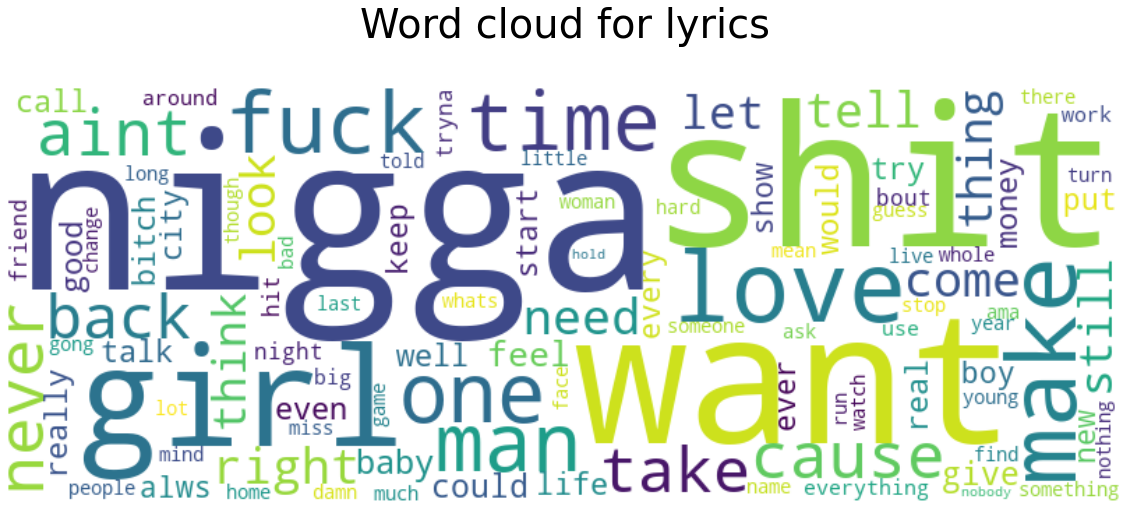

In [45]:
# Create a dictionary of most frequent terms ((required for word clouds)

term_dict = term_df.set_index('term')['frequency'].to_dict()

# Create a wordcloud of most frequent terms

wc = WordCloud(width=800, height=300, background_color="white",
               max_words=100)

wc.generate_from_frequencies(term_dict)

# Display the cloud

plt.figure(figsize=(20, 10))
plt.title("Word cloud for lyrics", fontsize = 40, pad = 50 )
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [46]:
term_df_no_n = term_df.iloc[1: , :]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


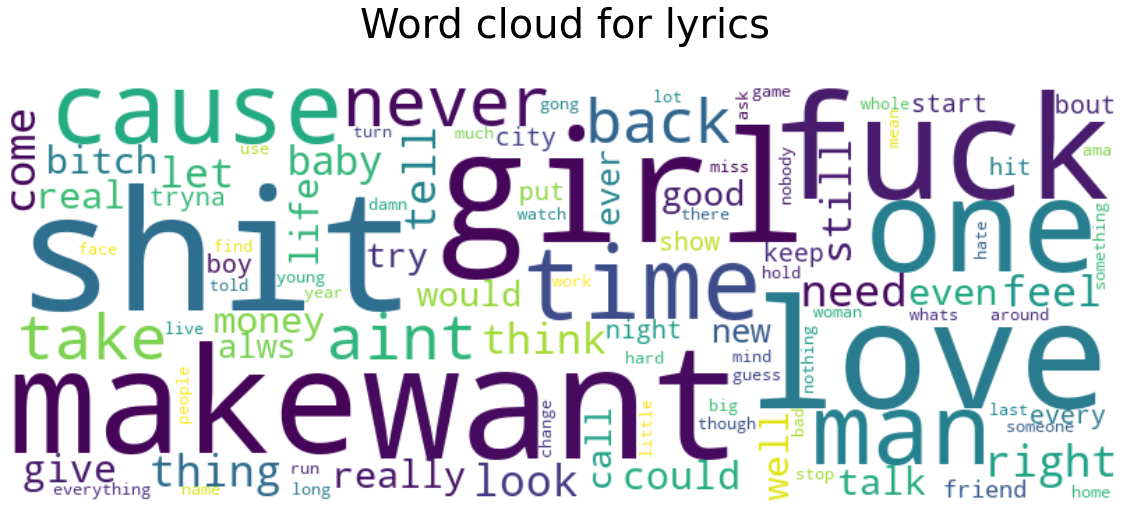

In [47]:
# Create a dictionary of most frequent terms ((required for word clouds)

term_dict = term_df_no_n.set_index('term')['frequency'].to_dict()

# Create a wordcloud of most frequent terms

wc = WordCloud(width=800, height=300, background_color="white",
               max_words=100)

wc.generate_from_frequencies(term_dict)

# Display the cloud

plt.figure(figsize=(20, 10))
plt.title("Word cloud for lyrics", fontsize = 40, pad = 50 )
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment

In [48]:
# Assign sentiment to each lyric
artist_df["sentiment"] = artist_df.lyrics.apply(lambda x: TextBlob(x).sentiment.polarity)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-48-d312c35c4e1f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_df["sentiment"] = artist_df.lyrics.apply(lambda x: TextBlob(x).sentiment.polarity)


In [49]:
artist_df.sort_values(by="sentiment", ascending=False).head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_title,title,artist,lyrics,featured_artists,release_date,sentiment
194,Bria's Interlude by Drake (Ft. Omarion),Bria’s Interlude,Drake,even though alone alone want keep warm come ba...,"[{'api_path': '/artists/2052', 'header_image_u...",2009-02-13,0.490000
181,Find Your Love by Drake,Find Your Love,Drake,option hey hey hey refuse forgotten hey hey he...,[],2010-05-05,0.371104
74,Signs by Drake,Signs,Drake,champagne breakfast yawn drink start morning l...,[],2017-06-22,0.363722
260,Loving You No More by Drake (Ft. Dirty Money),Loving You No More,Drake,hard breathe air call love aint nothing bad hu...,"[{'api_path': '/artists/2467906', 'header_imag...",2010-09-21,0.353125
248,Like I’m Supposed To/Do Things by Drake,Like I’m Supposed To/Do Things,Drake,hand tie someone ear side tell mind want night...,[],None,0.341429
62,Best I Ever Had by Drake,Best I Ever Had,Drake,lot girl think song confuse one baby everythin...,[],2009-02-13,0.336435
20,Too Good by Drake (Ft. Rihanna),Too Good,Drake,look talk ask friend alws feel need tell thing...,"[{'api_path': '/artists/89', 'header_image_url...",2016-04-29,0.331789
189,Show Me a Good Time by Drake,Show Me a Good Time,Drake,end right thing one try forget take shot let l...,[],2010-06-15,0.325373
154,Madiba Riddim by Drake,Madiba Riddim,Drake,tell friend need distance gon teach love god t...,[],2017-03-18,0.322902
291,All This Love by Drake (Ft. Voyce),All This Love,Drake,southern smoke another one boy gon tell people...,"[{'api_path': '/artists/2050', 'header_image_u...",2006-02-14,0.315901


In [50]:
artist_df['Datetime'] = pd.to_datetime(df['release_date'], format="%Y/%m/%d")
artist_df = artist_df.sort_values(by = "Datetime")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-50-20a3b369a7a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_df['Datetime'] = pd.to_datetime(df['release_date'], format="%Y/%m/%d")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


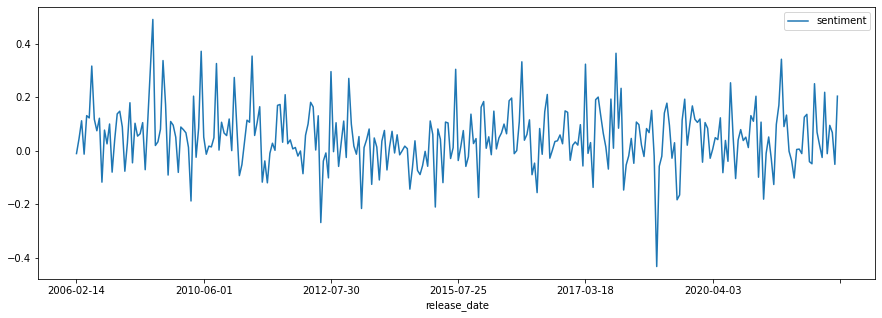

In [51]:
plt = artist_df.plot(x = 'release_date', y = 'sentiment', figsize=(15, 5))

In [52]:
artist_df.describe()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentiment
count,300.000000
mean,0.049011
std,0.114504
min,-0.432987
25%,-0.014127
50%,0.041136
75%,0.107093
max,0.490000
